# YDB SQLAlchemy + Jupyter Notebook Example

## Prepare simple dataset

### Download

In this example we will use [Mall Customers Dataset](https://www.kaggle.com/datasets/hosammhmdali/mall-customers-dataset)

First of all, we should download it and get path to csv file:

In [1]:
%pip install kagglehub --quiet

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("hosammhmdali/mall-customers-dataset")

# Retrieve csv file path
dataset_dir = os.listdir(path)
dataset_name = [name for name in dataset_dir if name.endswith(".csv")]
dataset_path = f"{path}/{dataset_name[0]}"
dataset_path


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/ovcharuk/work/ydb-python-examples/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/Users/ovcharuk/.cache/kagglehub/datasets/hosammhmdali/mall-customers-dataset/versions/1/Mall_Customers.csv'

Let's take a look how this dataset looks like

In [2]:
%pip install pandas --quiet
import pandas as pd
df = pd.read_csv(dataset_path)
df.head()


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Transform

Let's rename column names to get rid of spaces and simplify readability

In [3]:
df = df.rename(columns={
    "CustomerID": "id",
    "Genre": "sex",
    "Age": "age",
    "Annual Income (k$)": "income",
    "Spending Score (1-100)": "spending_score",
})
df.head()

,id,sex,age,income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Dataset is ready for work!

## Actions with YDB

### Create SQLAlchemy Engine and connect

First of all, we have to install YDB SA Dialect:

In [4]:
%pip install ydb-sqlalchemy==0.1.3 --quiet


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Target YDB installation uses service account to auth. In block below we load service accont json and install additional dependency to use SA auth.

Skip this part if your YDB installation uses another auth method.

In [5]:
%pip install yandexcloud --quiet

import json
sa_json_file_path = "/Users/ovcharuk/authorized_key.json"
with open(sa_json_file_path, 'r') as f:
    sa_json = json.load(f)


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.




Let's create SA engine and connection

In [6]:
import sqlalchemy as sa

args = {
    "_add_declare_for_yql_stmt_vars": True,
    "connect_args": {
        "protocol": "grpcs",
        "credentials": {
            "service_account_json": sa_json
        }
    }
}

engine = sa.create_engine("yql+ydb://ydb.serverless.yandexcloud.net:2135//ru-central1/b1g8skpblkos03malf3s/etnkr25d1qgm50un6sl1", **args)
conn = engine.connect()

Done! We are ready for work with YDB via sqlalchemy!

### Create database

There's no way to specify PK directly from `df.to_sql`, since `YDB` does not support tables without PK we have to prepare database first

In [7]:
table_name = "mall_customers"

conn.execute(sa.DDL(f"DROP TABLE IF EXISTS {table_name}"))
conn.execute(sa.DDL(
    f"""
    CREATE TABLE {table_name} (
	`id` Int64, 
	`sex` UTF8, 
	`age` Int64, 
	`income` Int64, 
	`spending_score` Int64,
    primary key (id)
    )
    """
))

### Pandas DataFrame integrations

YDB Dialect is compatible with `DataFrame.to_sql` and `DataFrame.read_sql*` operations. Let's show example how to use it.

*Note: Current YDB dialect version is not optimised to work with multiple inserts, it is better to use YDB CLI to load huge datasets to YDB.*

Loading dataframe to YDB table:

In [8]:
df.to_sql(table_name, conn, if_exists='append', index=False, method=None)

-1

Loading YQL Query ResultSet to DataFrame:

In [9]:
new_df = pd.read_sql(f"SELECT * FROM {table_name}", conn)
new_df

,age,id,income,sex,spending_score
0,19,1,15,Male,39
1,21,2,15,Male,81
2,20,3,16,Female,6
3,23,4,16,Female,77
4,31,5,17,Female,40
...,...,...,...,...,...
195,35,196,120,Female,79
196,45,197,126,Female,28
197,32,198,126,Male,74
198,32,199,137,Male,18


Loading full YDB table to DataFrame:

In [10]:
table_df = pd.read_sql_table(table_name, conn)
table_df

,id,sex,age,income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


That's it! From this moment you are free to do whatever you like with loaded DataFrame from YDB:

I0000 00:00:1732871554.047402 1744191 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='age', ylabel='spending_score'>

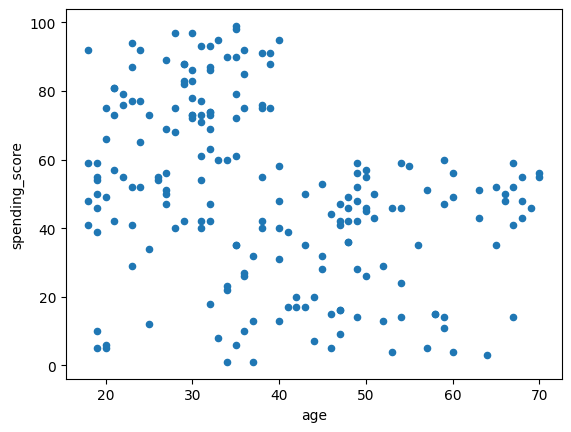

In [11]:
%pip install matplotlib --quiet
import matplotlib.pyplot as plt

table_df.plot(x='age', y='spending_score', kind='scatter')

### JupySQL integrations

YDB SQLAlchemy dialect is compatible with JupySQL. Let's install it and use `sql magic` comes with it.

In [12]:
%pip install jupysql --quiet
%load_ext sql

I0000 00:00:1732871555.087487 1744191 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


We should connect our SQLAlchemy engine with JupySQL:

In [13]:
%sql engine

Now we are free to use SQL expressions right from Notebook:

In [14]:
%sql SELECT * FROM mall_customers

Running query in 'yql+ydb://ydb.serverless.yandexcloud.net:2135//ru-central1/b1g8skpblkos03malf3s/etnkr25d1qgm50un6sl1'

200 rows affected.

age,id,income,sex,spending_score
19,1,15,Male,39
21,2,15,Male,81
20,3,16,Female,6
23,4,16,Female,77
31,5,17,Female,40
22,6,17,Female,76
35,7,18,Female,6
23,8,18,Female,94
64,9,19,Male,3
30,10,19,Female,72


In [15]:
%%sql
SELECT max(spending_score) as `max(spending_score)`
    FROM mall_customers
    WHERE sex = "Male" AND age < 30

Running query in 'yql+ydb://ydb.serverless.yandexcloud.net:2135//ru-central1/b1g8skpblkos03malf3s/etnkr25d1qgm50un6sl1'

1 rows affected.

max(spending_score)
97
